In [1]:
from __future__ import print_function, division

import time
import datetime
import os
import copy
from tqdm import tqdm

import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import random_split
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn
from torch.utils.tensorboard import SummaryWriter

import torchvision
from torchvision import datasets, models, transforms

cudnn.behchmark = True

In [2]:
BATCH_SIZE = 32

## Load Data

In [3]:
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

DATA_PATH = os.path.join(os.environ['DEV_PATH'], 'datasets/paddy-disease-classification')
TRAIN_PATH = os.path.join(DATA_PATH, 'train_images')
TEST_PATH = os.path.join(DATA_PATH, 'test_images')

image_dataset = datasets.ImageFolder(TRAIN_PATH, data_transforms['train'])
train, val = random_split(image_dataset, [0.8, 0.2])
image_datasets = {'train': train, 'val': val}
dataloaders = {
    x: torch.utils.data.DataLoader(
        image_datasets[x],
        batch_size=BATCH_SIZE,
        shuffle=True,
        num_workers=4,
    ) for x in ['train', 'val']
}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_dataset.classes

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

## Visualize a few images

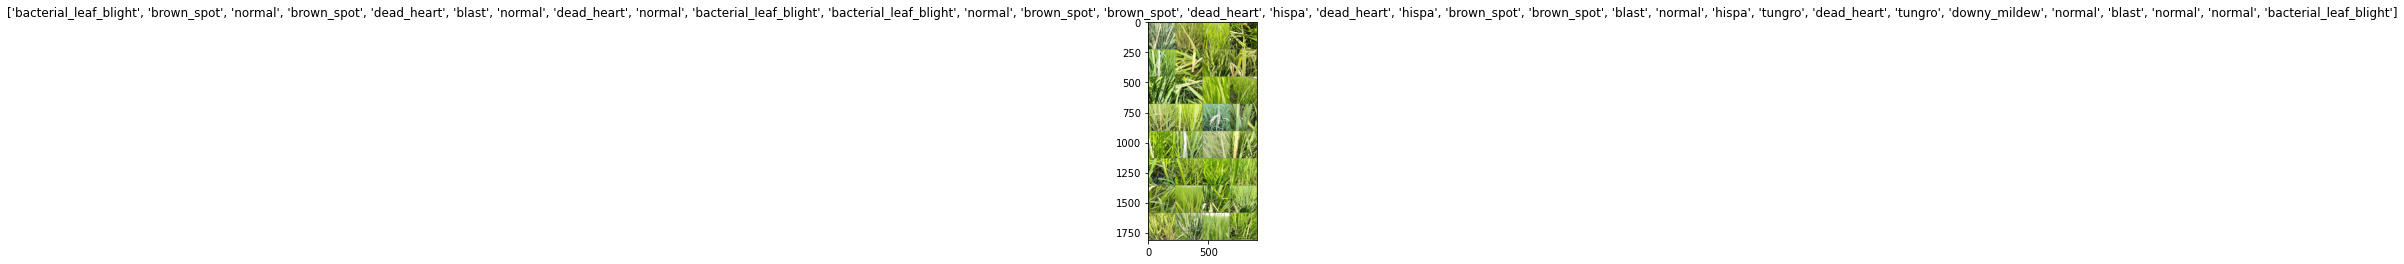

In [4]:
def imshow(inp, title=None):
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)

inputs, classes = next(iter(dataloaders['train']))

out = torchvision.utils.make_grid(inputs, nrow=4)

imshow(out, title=[class_names[x] for x in classes])

## Training the model

In [5]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25, writer=None):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print('-' * 10)

        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()
            else:
                model.eval()

            running_loss = 0.0
            running_corrects = 0

            for inputs, labels in tqdm(dataloaders[phase]):
                inputs = inputs.to(device)
                labels = labels.to(device)

                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            if writer is not None:
                writer.add_scalar(f'Loss/{phase}', epoch_loss, epoch)
                writer.add_scalar(f'Acc/{phase}', epoch_acc, epoch)

            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best val Acc: {best_acc:4f}')

    model.load_state_dict(best_model_wts)
    return model

## Visualizing the model predictions

In [6]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images // 2, 2, images_so_far)
                ax.axis('off')
                ax.set_title(f'predicted: {class_names[preds[j]]}')
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

## Finetuning the convnet

In [7]:
model_ft = models.vgg16(weights=models.VGG16_Weights.DEFAULT)
num_ftrs = model_ft.classifier[0].in_features

model_ft.classifier = nn.Sequential(
    nn.Linear(num_ftrs, 4096),
    nn.ReLU(),
    nn.Dropout(p=0.5),
    nn.Linear(4096, 4096),
    nn.ReLU(),
    nn.Dropout(p=0.5),
    nn.Linear(4096, 10),
    nn.Softmax(dim=1),
)

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

## Train and evaluate

In [ ]:
writer = SummaryWriter('runs/vgg16/' + datetime.datetime.now().strftime('%Y%m%d_%H%M%S'))
model_ft = train_model(
    model_ft, criterion, optimizer_ft, exp_lr_scheduler,
    num_epochs=50, writer=writer
)
writer.close()
torch.save(model_ft, 'vgg16_all.pth')

In [ ]:
visualize_model(model_ft)

## Fixed feature extractor

In [ ]:
model_conv = models.vgg16(weights=models.VGG16_Weights.DEFAULT)
for param in model_conv.parameters():
    param.requires_grad = False

num_ftrs = model_conv.classifier[0].in_features
model_conv.classifier = nn.Sequential(
    nn.Linear(num_ftrs, 4096),
    nn.ReLU(),
    nn.Dropout(p=0.5),
    nn.Linear(4096, 4096),
    nn.ReLU(),
    nn.Dropout(p=0.5),
    nn.Linear(4096, 10),
    nn.Softmax(dim=1),
)

model_conv = model_conv.to(device)

criterion = nn.CrossEntropyLoss()

optimizer_conv = optim.SGD(model_conv.classifier.parameters(), lr=0.001, momentum=0.9)

exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)

## Train and evaluate

In [ ]:
writer = SummaryWriter('runs/vgg16/' + datetime.datetime.now().strftime('%Y%m%d_%H%M%S'))
model_conv = train_model(
    model_conv, criterion, optimizer_conv, exp_lr_scheduler,
    num_epochs=25, writer=writer
)
writer.close()
torch.save(model_conv, 'vgg16_classifier.pth')

In [ ]:
visualize_model(model_conv)